<a href="https://colab.research.google.com/github/onlyabhilash/ML-Notebooks/blob/main/Transformers/Extractive_Question_Answering_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.kaggle.com/code/ritvik1909/question-answering-attention/" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
%%capture
!pip install datasets

In [ ]:
from datasets import load_dataset
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as L
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Getting the Data

In this notebook we will be working on SubjQA dataset which is available on the huggingface datasets

SubjQA is a question answering dataset that focuses on subjective (as opposed to factual) questions and answers. The dataset consists of questions over reviews from 6 different domains: books, movies, grocery, electronics, TripAdvisor (i.e. hotels), and restaurants. 

In [ ]:
# Utility function to convert huggingface dataset into a pandas dataframe
def get_dataframe(dataset, subset):
  df = pd.DataFrame(dataset[subset])[['context', 'question', 'answers']]
  df['answers'] = df['answers'].apply(lambda x: x['text'][0] if len(x['text']) > 0 else np.nan )
  return df

In [ ]:
%%capture
# Getting the datasets for all 6 domains
df_train = []
df_valid = []
df_test = []
configs = ['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']
for config in configs:
  temp = load_dataset("subjqa", config)

  temp_train = get_dataframe(temp, "train").dropna().reset_index(drop=True)
  temp_train['group'] = config
  df_train.append(temp_train)

  temp_valid = get_dataframe(temp, "validation").dropna().reset_index(drop=True)
  temp_valid['group'] = config
  df_valid.append(temp_valid)

  temp_test = get_dataframe(temp, "test").dropna().reset_index(drop=True)
  temp_test['group'] = config
  df_test.append(temp_test)

df_train = pd.concat(df_train).reset_index(drop=True)
df_valid = pd.concat(df_valid).reset_index(drop=True)
df_test = pd.concat(df_test).reset_index(drop=True)

In [ ]:
print(f"# training examples: {len(df_train)}, validation examples: {len(df_valid)}, testing examples: {len(df_test)}")
print("Training Set:")
df_train.head()

# training examples: 3276, validation examples: 647, testing examples: 999
Training Set:


,context,question,answers,group
0,While I would not recommend this book to a you...,What are the parts like?,This is a wonderfully written book,books
1,While I would not recommend this book to a you...,How is the detail?,the subject matter would be interesting,books
2,"I loved the movie, but the book is so much bet...",How would you describe the story?,the book is so much better,books
3,This book is very enjoyable from beginning to ...,How is story?,revolves around Jakob a retired circus vet which,books
4,I enjoyed this book very much. The writing is ...,How is Robinson's prose?,The writing is interesting and detailed. Gripp...,books


# Data Preparation
After fetching the dataset and organising them as dataframes, we wil start tokenizing the data and preparing actual tensors for our model to train on.

Our model would take in 2 inputs, ie context and question, and based on that it should be able to find a substring of the context as the answer to the question.

Since answer is a substring of the context, we will use the same tokenizer for context and answer.

In [ ]:
MAX_LEN = 512

context_tokenizer = Tokenizer()
context_tokenizer.fit_on_texts(df_train.context.fillna(''))

question_tokenizer = Tokenizer()
question_tokenizer.fit_on_texts(df_train.question.fillna(''))

We will prepare the context, question and answer tensors:
* tokenize and pad the context using context tokenizer to form context tensor
* tokenize and pad the answer using context tokenizer
* calculate the beginning and ending index of answer sub array in the context array as one hot encoded arrays and pad them
* tokenize and pad the question using question tokenizer to form question tensor
* concatenate beginning and ending indicies tensors to form the answer tensor

In [ ]:
# Utility function to get the tensors from the dataframe
def get_tensors(df):
  context = context_tokenizer.texts_to_sequences(df.context.fillna(''))
  answers = context_tokenizer.texts_to_sequences(df.answers.fillna(''))
  beg_pos = [[1 if a[x:x+len(b)] == b else 0 for x in range(len(a))] for a, b in zip(context, answers)]
  end_pos = [[1 if a[x:x+len(b)] == b else 0 for x in range(len(a))] for a, b in zip(context, answers)]
  question = question_tokenizer.texts_to_sequences(df.question.fillna(''))

  context = np.array(pad_sequences(context, maxlen=MAX_LEN, padding='post', truncating='post'))
  beg_pos = np.array(pad_sequences(beg_pos, maxlen=MAX_LEN, padding='post', truncating='post'))
  end_pos = np.array(pad_sequences(end_pos, maxlen=MAX_LEN, padding='post', truncating='post'))
  question = np.array(pad_sequences(question, maxlen=MAX_LEN, padding='post', truncating='post'))

  beg_pos = np.expand_dims(beg_pos, axis=2)
  end_pos = np.expand_dims(end_pos, axis=2)
  answer = np.concatenate((beg_pos, end_pos), axis=2)

  return context, question, answer

contexts_train, questions_train, answers_train   = get_tensors(df_train)
contexts_valid, questions_valid, answers_valid   = get_tensors(df_valid)
contexts_test, questions_test, answers_test   = get_tensors(df_test)

print(f"Shape of Context Tensor: {contexts_train.shape}, Question Tensor: {questions_train.shape}, Answers Tensor: {answers_train.shape}")

Shape of Context Tensor: (3276, 512), Question Tensor: (3276, 512), Answers Tensor: (3276, 512, 2)


# Model

Lets define a standard transformer encoder block

In [ ]:
class TransformerEncoder(L.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = L.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential([L.Dense(dense_dim, activation='relu'), L.Dense(embed_dim)])
        self.layernorm1 = L.LayerNormalization()
        self.layernorm2 = L.LayerNormalization()
    
    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[: tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm2(proj_input + proj_output)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim
        })
        return config

Lets define the model architecture

An Extractive Question Answering Model is pretty simple and similar to that of token classification, ie there are only a couple of changes, since we need two text inputs, we embed both of them and then pass through the encoder blocks and then we concatenate them, and the final output layer does a multilabel token classification with two classes, where 1 class represent beginning of answer and other class means end of the asnwer therefore the architechture looks something like:

* Input Layers
* Embeddingss
* Transformer Encoder Blocks
* Dropout (optional)
* Concatenation
* Classification Layer

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 context (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 question (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 context_embeddings (Embedding)  (None, 512, 50)     1382500     ['context[0][0]']                
                                                                                                  
 question_embeddings (Embedding  (None, 512, 50)     66800       ['question[0][0]']               
 )                                                                                            

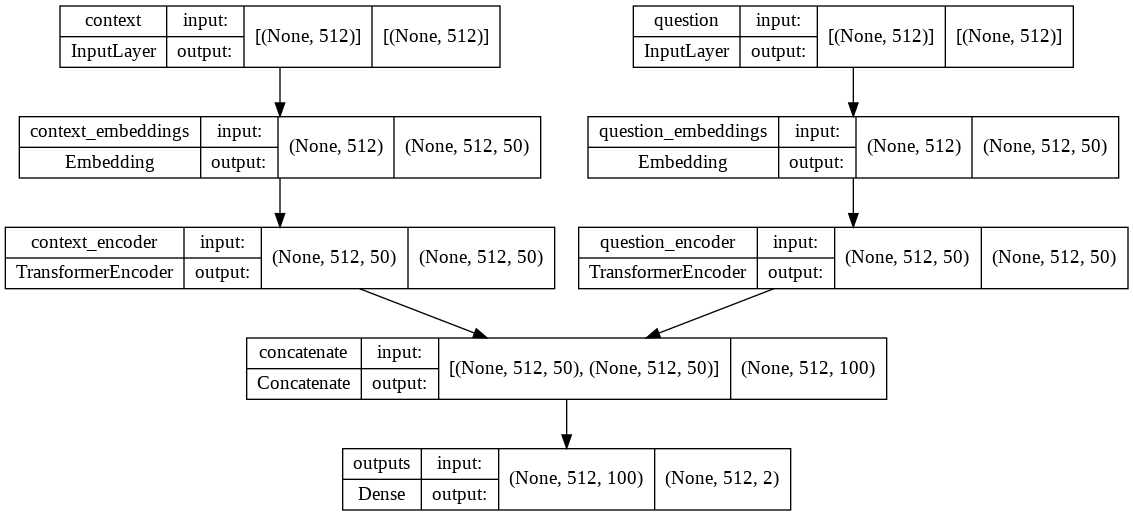

In [ ]:
EMBED_DIM = 50
DENSE_DIM = 64
NUM_HEADS = 4

context_inp = L.Input(shape=(MAX_LEN, ), name='context')
question_inp = L.Input(shape=(MAX_LEN, ), name='question')

context_emb = L.Embedding(
    len(context_tokenizer.word_index)+1, EMBED_DIM, name='context_embeddings'
)(context_inp)
question_emb = L.Embedding(
    len(question_tokenizer.word_index)+1, EMBED_DIM, name='question_embeddings'
)(question_inp)

context_emb = TransformerEncoder(EMBED_DIM, DENSE_DIM, NUM_HEADS, name='context_encoder')(context_emb)
question_emb = TransformerEncoder(EMBED_DIM, DENSE_DIM, NUM_HEADS, name='question_encoder')(question_emb)

concat_emb = L.Concatenate(axis=-1, name='concatenate')([context_emb, question_emb])

outputs = L.Dense(2, activation='sigmoid', name='outputs')(concat_emb)

model = keras.Model(inputs=[context_inp, question_inp], outputs=outputs)
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(1e-4))
model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
%%capture
es = keras.callbacks.EarlyStopping(min_delta=1e-4, patience=5, verbose=1, restore_best_weights=True)
rlp = keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
csv_logger = keras.callbacks.CSVLogger('training_log.csv')

history = model.fit(
    [contexts_train, questions_train], answers_train, validation_data=([contexts_valid, questions_valid], answers_valid),
    epochs=250, callbacks=[es, rlp, csv_logger]
)

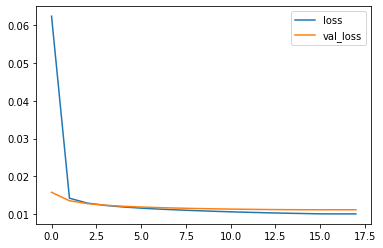

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot();

In [ ]:
idx = np.random.randint(0, contexts_test.shape[0])
query_context = contexts_test[idx:idx+1]
query_question = questions_test[idx:idx+1]
query_answer = answers_test[idx:idx+1]
query_ans_beg, query_ans_end  = np.ravel(answers_test[idx:idx+1].argmax(axis=1))
print('Context:', context_tokenizer.sequences_to_texts(query_context))
print('Question:', question_tokenizer.sequences_to_texts(query_question))
print('Answer:', context_tokenizer.sequences_to_texts([query_context[0][query_ans_beg: query_ans_end+1]]))
pred_ans_beg, pred_ans_end = np.ravel(model([query_context, query_question]).numpy().argmax(axis=1))
print('Predicted Answer:', context_tokenizer.sequences_to_texts([query_context[0][pred_ans_beg: pred_ans_end+1]]))

Context: ["i grew up on homemade andamaranth graham crackers only having the honey maid at friend's houses so for me the honey maid were a very sweet treat much like cookies and too sweet to eat more than one sheet my husband grew up on honey maid graham crackers he thinks the amaranth are too bland and without flavor i think the honey maid are too sweet and dislike the flavor of the enriched flour versus the whole grain that i'm used to i was going to say that these were a good balance between the two extremes but both of us actually prefer them to the graham crackers we grew up with they have more flavor than either the amaranth or the honey maid without being too sweet they are the closest i've ever tasted to homemade without all the effort of making them from scratch the hint of cinnamon is delicious they taste fantastic dipped in yogurt which is my husband's favorite way to eat them and bake up nicely as graham cracker crusts comparing them nutritionally to honey maid these are ma